In [1]:
import numpy as np
import pandas as pd
from plotnine import (
    ggplot, aes, geom_density, geom_line, geom_point, 
    geom_violin, facet_grid, labs, theme, facet_wrap,
)

# for rl training
from stable_baselines3 import PPO, TD3
from sb3_contrib import TQC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

# the rl environment
from rl4greencrab.envs.green_crab_monthly_env import greenCrabMonthEnv
from rl4greencrab.envs.green_crab_monthly_env_norm import greenCrabMonthEnvNormalized

# helper that paralelizes episode simulations for evaluation purposes (agent -> reward)
from rl4greencrab import evaluate_agent

# helper that creates a single episode simulation keeping track of many variables
# of the internal env state
from rl4greencrab import simulator

In [2]:
config = {"init_n_adult": 0}
gmonth = greenCrabMonthEnv()
gmonthNorm = greenCrabMonthEnvNormalized()
vec_env = make_vec_env(greenCrabMonthEnvNormalized, n_envs=12)

In [38]:
gmonthNorm.step(np.float32([-0.5, -0.5, -0.5]))

(array([-0.9983733], dtype=float32), -0.0062514270011736865, False, False, {})

In [3]:
model = PPO("MlpPolicy", vec_env, verbose=0, tensorboard_log="/home/rstudio/logs")
model.learn(
	total_timesteps=250_000, 
	progress_bar=True,
)
model.save("ppo_gcse_month_norm")

Output()

/opt/conda/lib/python3.12/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.


In [3]:
evalEnv = greenCrabMonthEnvNormalized()

In [17]:
ppoAgent = PPO.load("PPO_gcmenorm", device="cpu")
mean_rew, std_rew = evaluate_policy(ppoAgent, evalEnv)
print(f"PPO reward = {mean_rew:.5f} +/- {std_rew:.5f}")

PPO reward = -3.59045 +/- 1.05691


In [9]:
td3Agent = TD3.load("TD3_gcmenorm", device="cpu")
mean_rew, std_rew = evaluate_policy(td3Agent, evalEnv)
print(f"TD3 reward = {mean_rew:.5f} +/- {std_rew:.5f}")

/opt/conda/lib/python3.12/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.


TD3 reward = -3.13760 +/- 1.02406


In [20]:
evaluate_agent(agent=td3Agent,  env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=200)

-3.5265259674679212

In [21]:
import ray
ray.shutdown()

In [8]:
td3Data = simulator(env = evalEnv, agent = td3Agent).simulate_full_named_obs_acts()
td3DataDF = pd.DataFrame(td3Data)
td3DataDF.head()

,t,obs0,act0,act1,act2,rew,rep
0,0,-1.000000,0.081903,-0.272859,-0.025227,0.000000,0
1,1,-0.998362,0.081903,-0.272859,-0.025227,-0.021630,0
2,2,-0.998154,0.081903,-0.272859,-0.025227,-0.039316,0
3,3,-0.998283,0.081903,-0.272859,-0.025227,-0.054094,0
4,4,-0.998304,0.081903,-0.272859,-0.025227,-0.066722,0


<Axes: xlabel='t'>

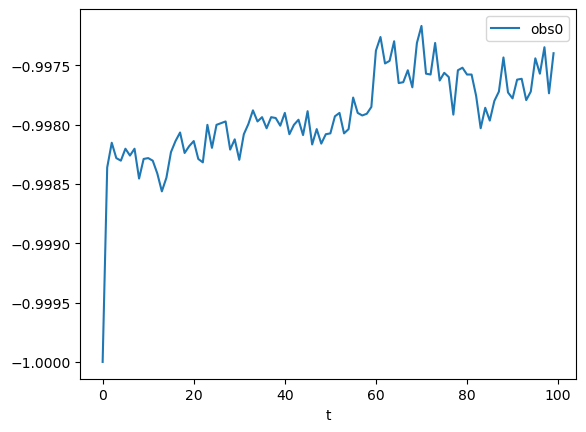

In [9]:
td3DataDF[td3DataDF.rep == 0].plot(x='t', y =['obs0'])

In [19]:
ppoData = simulator(env = evalEnv, agent = ppoAgent).simulate_full_named_obs_acts()
ppoDataDF = pd.DataFrame(ppoData)
ppoDataDF.head()

,t,obs0,act0,act1,act2,rew,rep
0,0,-1.000000,-0.606706,-0.880899,-0.249603,0.000000,0
1,1,-0.995423,-0.605517,-0.879170,-0.249243,-0.064581,0
2,2,-0.996035,-0.605676,-0.879401,-0.249291,-0.111151,0
3,3,-0.994959,-0.605396,-0.878994,-0.249206,-0.143909,0
4,4,-0.995404,-0.605512,-0.879163,-0.249241,-0.167351,0


<Axes: xlabel='t'>

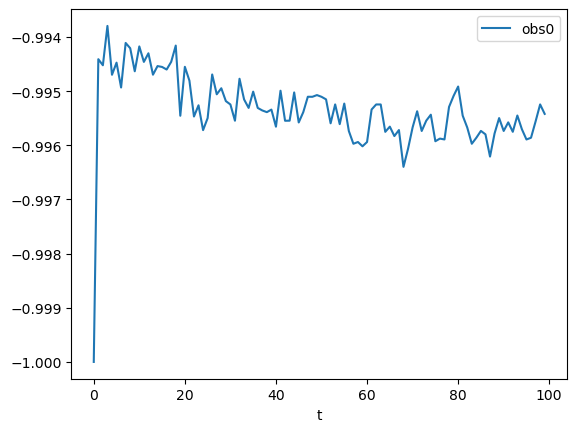

In [17]:
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['obs0'])